# CHALLENGE PROBLEM 1 CODE – Version 2  
2.156 ML & AI for Design Engineering  
Berfin Ataman & Sergio Mutis

-----------------------------------------------------------------------------------


# CP Instructions

In this challenge problem, the task is to design **2D planar linkage mechanisms** that can trace six given target curves (the “egg” paths). The optimization must balance **accuracy** (distance to target curve) and **efficiency** (total material used), while respecting complexity constraints.

### Constraints
Your solutions must satisfy all three of the following:
1. **Distance Constraint**: Mechanism’s traced curve must be within **0.75** distance of the target curve.  
2. **Material Constraint**: Total linkage length must be **≤ 10.0**.  
3. **Complexity Constraint**: Mechanisms may have at most **20 joints**.  

Mechanisms that violate these constraints will be discarded and will not count toward the score.

### Objective & Scoring
- Each mechanism is evaluated on **two objectives**:  
  - Distance to target curve (minimize).  
  - Material usage (minimize).  
- Performance is measured using the **hypervolume (HV)** indicator with reference point **(0.75, 10.0)**.  
- For each target curve, you may submit up to **1000 mechanisms**.  
- The **average hypervolume across all six target curves** determines your final score.

### Optimization Methods
You are expected to use and possibly combine the following strategies:
- **Genetic Algorithms (GA):** Optimize both mechanism structures (edges, connectivity) and joint positions. You may experiment with:
  - Preprocessing or filtering random mechanisms before GA.  
  - Modified mutation and crossover operators.  
  - Mixed-variable GA setups using connectivity matrices.  
- **Gradient-Based Optimization (GD):** Use differentiable tools to optimize joint positions. Consider gradients of both objectives (distance and material).  
- **Hybrid / Iterative Approaches:**  
  - Cycle between GA and GD to refine solutions.  
  - Compare and save improved populations incrementally (keep solutions only if they improve HV).  
  - Explore more efficient mechanism representations to reduce parameter space.

### Deliverables
For each of the six target curves:  
- Generate and submit up to **1000 valid mechanisms**.  
- Ensure mechanisms are evaluated with the provided tools (`Tools`, `DifferentiableTools`).  
- Organize results so that **hypervolumes can be calculated and compared** against baseline solutions.  

Your goal is to maximize the average hypervolume score across all six problems by producing mechanisms that are both accurate and efficient under the given constraints.

----------------------------------------------------------------------------------------

# Method Outline
1. Setup  
2. Initial Population  
3. GA Optimization  
4. GD Refinement  
5. Compare and Save Improved Solutions  

# LOG
- Step 1: Cleaned the advance notebook to be more streamlined (SM)  
- Step 1: Parametriced the curve to run all optimizations by updating the curve (SM)  
- Step 2: Improved Initial Population (SM)  
   - Generate seeds at fixed size N=7 to match GA encoding  
   - Filter out invalid mechanisms (distance > 0.75, material > 10, >20 joints)  
   - Early-stop once enough feasible seeds collected  
   - Apply ε-deduplication + non-dominated filtering + max–min spread to select diverse seeds  
   - Added progress bars and diagnostics for visibility  
- Step 5: Added a 'Compare and Save Improved Solutions' (SM)  
   - Compares the hypervolume of the new set of solutions to the previous hypervolume, then save only if the new solutions are better for that curve. (incremental improvement)  

# TO-DO
- Step 2: GA Multi-N generation  
- Step 4: GD make GD a function of both material and distance  
- Step 4: GD add adaptive decay  
- Step 5: Compare & Save update → union old + new, Pareto-prune, recompute HV, and save  
   - Ensures HV never decreases; if capped at 1000, apply HV-aware pruning with fallback  
- General: Batch curve optimization (run on multiple indexes at once)  
- General: Batch run seed (run GA+GD multiple times with different seeds → union results → prune to top 1000 HV)  
- General: Parameterize optimization hyperparameters (pop_size, n_gen, per_size, target_valid, eps, GD step size, etc.) for easier tuning




# Official Hints:
- Why not do some preprocessing to random mechanisms before running GA?
- Can you use the gradients of both functions in gradient based optimization? 
- Can you cycle through multiple optimization runs?
- Can you mix different kinds of GA? We showed how GA can be used for a single mechanism skeleton and how it can be used to also create the mechanisms?
- Can you modify the GA mutations and cross-over?
- Is there a more efficient representation of mechanisms we can use?
- Are there smarter gradient-based optimization methods?

___________________________________________________________________________________________

# 1. SETUP!

Target Optimization Curve

In [37]:
# --- Configurable target curve ---
curve_index = 0   # 0-based index: 0 = Problem 1, 1 = Problem 2, ..., 5 = Problem 6

a. Environment Setup

In [38]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"  # Disable GPU for JAX (Remove if you want to use GPU)

import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm, trange

# deteministic random numbers
np.random.seed(0)
random.seed(0)

b. Load Tarject Cruves

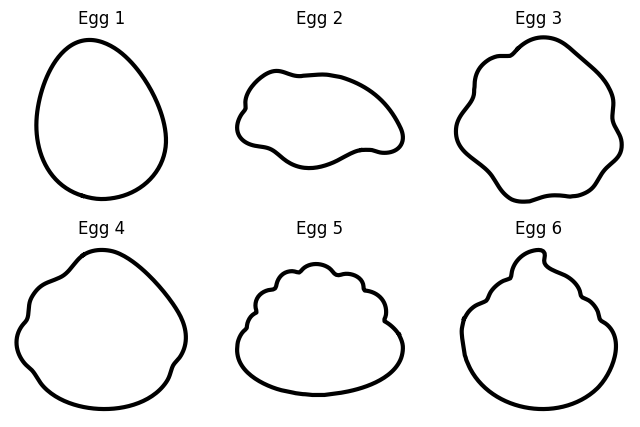

In [39]:
target_curves = np.load('target_curves.npy')

# Plot all target curves

# Initialize a 2x3 subplot for plotting all target curves
fig, axs = plt.subplots(2, 3, figsize=(8, 5))

# Loop through the 6 target curves to plot them
for i in range(6):
    # Extract x and y coordinates from the target curve
    x_coords = np.array(target_curves[i])[:, 0]
    y_coords = np.array(target_curves[i])[:, 1]

    # Plot the curve on the respective subplot
    axs[i // 3, i % 3].plot(x_coords, y_coords, color='black', linewidth=3)

    # Set title for each subplot
    axs[i // 3, i % 3].set_title(f'Egg {i + 1}')

    # Ensure equal scaling for x and y axes
    axs[i // 3, i % 3].axis('equal')
    axs[i // 3, i % 3].axis('off')


c. Optimization Imports

In [40]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling, Sampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize

from LINKS.Optimization import DifferentiableTools, Tools

d. Problem Definition (Tools + Pymoo class)

In [41]:
PROBLEM_TOOLS = Tools( # we have to define this outside the class due to pymoo deepcopy limitations
            device='cpu' # device to run the optimization on
        )  
PROBLEM_TOOLS.compile() # compile the functions for faster runs

class mechanism_synthesis_optimization(ElementwiseProblem):

    # When intializing, set the mechanism size and target curve
    def __init__(self, target_curve, N = 5):
        self.N = N
        variables = dict()

        # The upper triangular portion of our NxN Connectivity Matrix consists of Nx(N-1)/2 boolean variables:
        for i in range(N):
            for j in range(i):
                variables["C" + str(j) + "_" + str(i)] = Binary()

        # We Delete C0_1 since we know node 1 is connected to the motor
        del variables["C0_1"]

        #Our position matrix consists of Nx2 real numbers (cartesian coordinate values) between 0 and 1
        for i in range(2*N):
            variables["X0" + str(i)] = Real(bounds=(0.0, 1.0))

        # Our node type vector consists of N boolean variables (fixed vs non-fixed)
        for i in range(N):
            variables["fixed_nodes" + str(i)] =  Binary(N)

        # Our target node is an integer between 1 and N-1, (any except the motor node).
        variables["target"] = Integer(bounds=(1,N-1))

        # Set up some variables in the problem class we inherit for pymoo
        # n_obj=number of objectives, n_constr=number of constraints
        # Our objectives are chamfer distance and material, and they both have constraints.
        super().__init__(vars=variables, n_obj=2, n_constr=2)

        # Store the target curve point cloud
        self.target_curve = target_curve


    def convert_1D_to_mech(self, x):
        N = self.N

        # Get target joints index
        target_idx = x["target"]

        # Build connectivity matrix from its flattened constitutive variables
        C = np.zeros((N,N))
        x["C0_1"] = 1

        for i in range(N):
            for j in range(i):
                # C[i,j] = x["C" + str(j) + "_" + str(i)]
                C[j,i] = x["C" + str(j) + "_" + str(i)]

        edges = np.array(np.where(C==1)).T
        
        # Reshape flattened position matrix to its proper Nx2 shape
        x0 = np.array([x["X0" + str(i)] for i in range(2*N)]).reshape([N,2])

        # Extract a list of Nodes that are fixed from boolean fixed_nodes vector
        fixed_joints = np.where(np.array([x["fixed_nodes" + str(i)] for i in range(N)]))[0].astype(int)

        #We fix the motor and original ground node as 0 and 1 respectively in this implementation
        motor=np.array([0,1])

        return x0, edges, fixed_joints, motor, target_idx

    def convert_mech_to_1D(self, x0, edges, fixed_joints, target_idx=None, **kwargs):
        # This function assumes motor to be [0, 1] our random mechanism generator automatically does this
        N = self.N

        # Initialize dictionary to store 1D representation of mechanism
        x = {}

        # Store target node value
        if target_idx is None:
            target_idx = x0.shape[0]-1 # Assume last node is the target if not specified
            
        x["target"] = target_idx

        # Store connectivity matrix in its flattened form
        C = np.zeros((N,N), dtype=bool)
        C[edges[:,0], edges[:,1]] = 1
        C[edges[:,1], edges[:,0]] = 1
       
        for i in range(N):
            for j in range(i):
                x["C" + str(j) + "_" + str(i)] = C[i,j]

        del x["C0_1"]
        
        # Store position matrix in its flattened form
        if x0.shape[0] != N:
            x0 = np.pad(x0, ((0, N - x0.shape[0]), (0, 0)), 'constant', constant_values=0)
            
        for i in range(2*N):
            x["X0" + str(i)] = x0.flatten()[i]

        # Store fixed nodes in boolean vector form
        for i in range(N):
            x["fixed_nodes" + str(i)] = (i in fixed_joints) or (i>=N)

        return x

    def _evaluate(self, x, out, *args, **kwargs):
        #Convert to mechanism representation
        x0, edges, fixed_joints, motor, target_idx = self.convert_1D_to_mech(x)
        
        # Simulate
        distance, material = PROBLEM_TOOLS(x0,
                                edges,
                                fixed_joints,
                                motor,
                                self.target_curve,
                                target_idx=target_idx
                            )

        out["F"] = np.array([distance, material])
        out["G"] = out["F"] - np.array([0.75, 10.0])  # Constraints: distance <= 0.75, material <= 10.0


# 2. Initial Population

a. Imports and helpers

In [42]:
# === Section 2 — Cell 1: Seeding utilities (single-size, early-stop, ε-dedup) ===
from LINKS.Optimization import MechanismRandomizer, Tools
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from tqdm.auto import tqdm
import numpy as np
from time import perf_counter
from collections import defaultdict

# Use the same device everywhere
TOOLS = Tools(device='cpu')
TOOLS.compile()

def epsilon_dedup(F, eps=(5e-4, 5e-3)):
    """
    Keep at most one point per epsilon-box in (distance, material) objective space.
    eps is (eps_distance, eps_material).
    """
    if len(F) == 0:
        return np.array([], dtype=int)
    keys = (np.floor(F[:,0]/eps[0]).astype(int), np.floor(F[:,1]/eps[1]).astype(int))
    seen, keep = set(), []
    for i, key in enumerate(zip(*keys)):
        if key not in seen:
            seen.add(key)
            keep.append(i)
    return np.array(keep, dtype=int)

def generate_pool_single_size(n=7, per_size=200, desc="Sampling mechanisms"):
    """
    Randomize mechanisms at exactly size n (to match GA encoding N=n).
    """
    t0 = perf_counter()
    pool = []
    randomizer = MechanismRandomizer(min_size=n, max_size=n, device='cpu')
    for _ in tqdm(range(per_size), desc=f"{desc} n={n}", leave=False):
        pool.append(randomizer(n=n))
    print(f"[seed] sampled {len(pool)} candidates at n={n} in {perf_counter()-t0:.1f}s")
    return pool

def evaluate_mechs(mechs, target_curve, problem, diag_every=200,
                   distance_max=0.75, material_max=10.0, max_joints=20,
                   target_valid=120):
    """
    Evaluate pool, keep only constraint-satisfying candidates, show running diagnostics.
    Early-stops once target_valid feasible candidates are collected.
    """
    t0 = perf_counter()
    X_dicts, F_list, valid = [], [], []
    size_hist = defaultdict(int)
    best = {"distance": np.inf, "material": np.inf}
    ref = np.array([distance_max, material_max])

    pbar = tqdm(total=len(mechs), desc="[eval] checking constraints", leave=False)
    for i, mech in enumerate(mechs, 1):
        x0, edges, fixed_joints, motor = mech['x0'], mech['edges'], mech['fixed_joints'], mech['motor']
        # default: last node is target
        distance, material = TOOLS(x0, edges, fixed_joints, motor, target_curve, target_idx=x0.shape[0]-1)

        best["distance"] = min(best["distance"], distance)
        best["material"] = min(best["material"], material)

        if (distance <= distance_max) and (material <= material_max) and (x0.shape[0] <= max_joints):
            X = problem.convert_mech_to_1D(x0=x0, edges=edges, fixed_joints=fixed_joints,
                                           target_idx=x0.shape[0]-1, motor=motor)
            X_dicts.append(X)
            F_list.append([distance, material])
            valid.append(mech)
            size_hist[x0.shape[0]] += 1

        if (i % diag_every == 0) or (i == len(mechs)):
            acc = len(X_dicts) / i
            pbar.set_postfix({
                "seen": i,
                "valid": len(X_dicts),
                "acc%": f"{100*acc:.1f}",
                "best_d": f"{best['distance']:.3f}",
                "best_m": f"{best['material']:.3f}"
            })
        pbar.update(1)

        # Early stop if we hit target_valid feasible seeds
        if len(X_dicts) >= target_valid:
            break

    pbar.close()

    F = np.array(F_list) if F_list else np.zeros((0,2))
    print(f"[eval] done in {perf_counter()-t0:.1f}s | valid={len(X_dicts)} "
          f"({100*len(X_dicts)/max(1, min(len(mechs), i)):.1f}%)")
    if len(X_dicts):
        print(f"[eval] valid F ranges: distance [{F[:,0].min():.3f}, {F[:,0].max():.3f}] | "
              f"material [{F[:,1].min():.3f}, {F[:,1].max():.3f}] | ref={tuple(ref)}")
        sizes_sorted = sorted(size_hist.items())
        dist_str = ", ".join([f"n={k}:{v}" for k,v in sizes_sorted])
        print(f"[eval] size distribution among valid: {dist_str}")
    return X_dicts, F, valid

def select_diverse_non_dominated(X_dicts, F, k=100, title="[seed selection]"):
    """
    1) Non-dominated filter, 2) Max-min spread selection to k.
    (Assumes ε-dedup already applied if desired.)
    """
    if len(X_dicts) == 0:
        print(f"{title} no candidates to select."); return []
    nds = NonDominatedSorting().do(F, only_non_dominated_front=True)
    X_nd, F_nd = [X_dicts[i] for i in nds], F[nds]
    print(f"{title} non-dominated front size: {len(X_nd)}")

    if len(X_nd) <= k:
        print(f"{title} selected all {len(X_nd)} (<= k={k})")
        return X_nd

    # Greedy max-min spread
    chosen = [int(np.argmin(F_nd.sum(axis=1)))]
    dist = np.linalg.norm(F_nd - F_nd[chosen[0]], axis=1)
    for _ in tqdm(range(k-1), desc=f"{title} max-min pick", leave=False):
        next_i = int(np.argmax(dist))
        chosen.append(next_i)
        dist = np.minimum(dist, np.linalg.norm(F_nd - F_nd[next_i], axis=1))
    print(f"{title} selected k={k} diverse seeds")
    return [X_nd[i] for i in chosen]



b. Generate and evaluate pool

In [43]:
# === Section 2 — Cell 2: Build initial pool and filter (single-size matching GA N) ===
# IMPORTANT: Make sure GA encoding uses the same N below.
GA_N = 7  # must match the N used when you instantiate `problem` in Section 3

# Reuse your existing problem object if already defined earlier:
try:
    problem
except NameError:
    problem = mechanism_synthesis_optimization(target_curves[curve_index], N=GA_N)

# Step 1: generate pool (exactly n=GA_N to avoid padding artifacts)
raw_pool = generate_pool_single_size(n=GA_N, per_size=200)  # tweak per_size if needed

# Step 2: evaluate and filter with early-stop
X_dicts, F, valid_mechs = evaluate_mechs(
    raw_pool,
    target_curve=target_curves[curve_index],
    problem=problem,
    diag_every=200,
    distance_max=0.75,   # you can tighten (e.g., 0.60) to bias better seeds
    material_max=10.0,   # you can tighten (e.g., 9.0) to leave headroom
    max_joints=20,
    target_valid=120     # early-stop once we have enough good seeds
)


Sampling mechanisms n=7:   0%|          | 0/200 [00:00<?, ?it/s]

[seed] sampled 200 candidates at n=7 in 11.6s


[eval] checking constraints:   0%|          | 0/200 [00:00<?, ?it/s]

[eval] done in 1.2s | valid=1 (0.5%)
[eval] valid F ranges: distance [0.587, 0.587] | material [5.386, 5.386] | ref=(np.float64(0.75), np.float64(10.0))
[eval] size distribution among valid: n=7:1


c. Select initial population

In [44]:
# === Section 2 — Cell 3: ε-dedup + pick diverse non-dominated seeds ===
# Optional ε-dedup before selecting spread to reduce near-duplicates
if len(F) > 0:
    dd_idx = epsilon_dedup(F, eps=(5e-4, 5e-3))  # tweak eps if too aggressive
    X_dd = [X_dicts[i] for i in dd_idx]
    F_dd = F[dd_idx]
else:
    X_dd, F_dd = [], F

initial_population = select_diverse_non_dominated(X_dd, F_dd, k=100, title="[seed selection]")
print(f"[seed] → init pop size: {len(initial_population)}")



[seed selection] non-dominated front size: 1
[seed selection] selected all 1 (<= k=100)
[seed] → init pop size: 1


# 3. GA Optimization

b. GA Optimization Setup

In [45]:
# === GA Optimization Setup (using seeded initial_population) ===
# expects: `problem` already defined and `initial_population` from Section 2

try:
    seeded = initial_population  # from Section 2
except NameError:
    # Fallback: build from prior `mechanisms` if Section 2 wasn't run
    seeded = [problem.convert_mech_to_1D(**mech) for mech in mechanisms]
    print("[warn] Using fallback seeds from `mechanisms` (run Section 2 for better seeds).")

if len(seeded) == 0:
    raise ValueError("No seeds available. Ensure Section 2 created a non-empty `initial_population`.")

class sample_from_seeds(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        return np.array([seeded[i % len(seeded)] for i in range(n_samples)], dtype=object)

F = problem.evaluate(np.array(seeded, dtype=object))[0]
print(f"[seed] count={len(seeded)} | "
      f"dist[min/mean]={F[:,0].min():.3f}/{F[:,0].mean():.3f} | "
      f"mat[min/mean]={F[:,1].min():.3f}/{F[:,1].mean():.3f}")


[seed] count=1 | dist[min/mean]=0.587/0.587 | mat[min/mean]=5.386/5.386


c. GA Optimization

In [46]:
algorithm = NSGA2(pop_size=100,
                  sampling=sample_from_seeds(),
                  mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                  mutation=PolynomialMutation(prob=0.5),
                  eliminate_duplicates=MixedVariableDuplicateElimination())

results = minimize(problem,
                algorithm,
                ('n_gen', 100),
                verbose=True,
                save_history=True,
                seed=123
                )

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        1 |      1 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      101 |      3 |  0.000000E+00 |           INF |  1.7314422982 |         ideal
     3 |      201 |      3 |  0.000000E+00 |           INF |  0.000000E+00 |             f
     4 |      301 |      3 |  0.000000E+00 |           INF |  0.000000E+00 |             f
     5 |      401 |      3 |  0.000000E+00 |           INF |  0.000000E+00 |             f
     6 |      501 |      3 |  0.000000E+00 |  0.0647216100 |  0.000000E+00 |             f
     7 |      601 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0004239819 |             f
     8 |      701 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0757263538 |             f
     9 |      801 |      5 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    10 |      901 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0066597663 |             f

d. Hypervolume Check

Hyper Volume ~ 3.795211


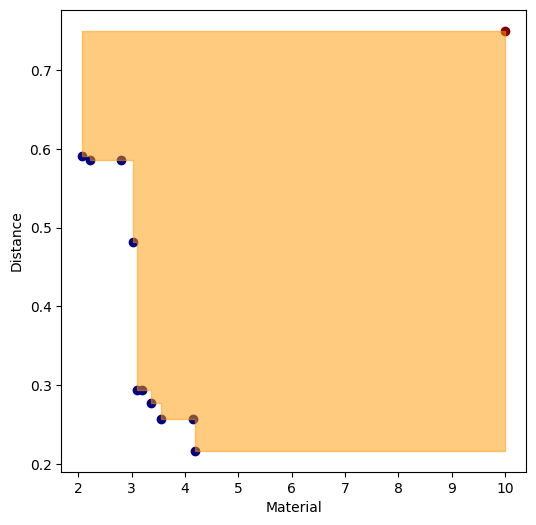

In [47]:
from LINKS.Visualization import GAVisualizer
from LINKS.Kinematics import MechanismSolver
from LINKS.Geometry import CurveEngine
from pymoo.indicators.hv import HV
ga_visualizer = GAVisualizer()
solver = MechanismSolver(device='cpu')
curve_engine = CurveEngine(device='cpu')

if not results.X is None:
    #Specify reference point
    ref_point = np.array([0.75, 10.0])

    #Calculate Hypervolume
    ind = HV(ref_point)
    hypervolume = ind(results.F)

    #Print and plot
    print('Hyper Volume ~ %f' %(hypervolume))
    ga_visualizer.plot_HV(results.F, ref_point, objective_labels=['Distance', 'Material']) #use the plot_HV function from utils
else:
    print('Did Not Find Solutions!!')

# 4. GD Optimization

a. GD Setup

In [48]:
from LINKS.Optimization import DifferentiableTools

differentiable_optimization_tools = DifferentiableTools(
    device='cpu' # device to run the optimization on
)  
differentiable_optimization_tools.compile() # compile the functions for faster runs

# lets make a batch from our GA results
x0s = []
edges = []
fixed_joints = []
motors = []
target_idxs = []
if not results.X is None:
    if not isinstance(results.X, dict):
        for i in range(results.X.shape[0]):
            x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member  = problem.convert_1D_to_mech(results.X[i])
            x0s.append(x0_member)
            edges.append(edges_member)
            fixed_joints.append(fixed_joints_member)
            motors.append(motor_member)
            target_idxs.append(target_idx_member)
    else:
        x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member  = problem.convert_1D_to_mech(results.X)
        x0s.append(x0_member)
        edges.append(edges_member)
        fixed_joints.append(fixed_joints_member)
        motors.append(motor_member)
        target_idxs.append(target_idx_member)

distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
    x0s,
    edges,
    fixed_joints,
    motors,
    target_curves[curve_index],
    target_idxs
)

# print(materials, distances)

GD Optimization - distance-based

In [49]:
x = x0s.copy()

step_size = 4e-4
n_steps = 1000

# keep track of which members are done optimizing
done_optimizing = np.zeros(len(x), dtype=bool)

x_last = x.copy()

for step in trange(n_steps):
    
    # get current distances, materials and gradients
    distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
        x,
        edges,
        fixed_joints,
        motors,
        target_curves[curve_index],
        target_idxs
    )
    
    # only update members that are valid and not done optimizing
    valids = np.where(np.logical_and(distances <= 0.75, materials <= 10.0))[0]
    invalids = np.where(~np.logical_and(distances <= 0.75, materials <= 10.0))[0]
    
    # if a member is invalid, revert to last step and mark as done optimizing
    for i in invalids:
        done_optimizing[i] = True
        x[i] = x_last[i]
    
    # keep a copy of last step
    x_last = x.copy()
    
    # update valid members
    for i in valids:
        if done_optimizing[i]:
            continue
        x[i] = x[i] - step_size * distance_grads[i]
        
    if np.all(done_optimizing):
        print(f'All members are done optimizing at step {step}')
        break

  0%|          | 0/1000 [00:00<?, ?it/s]

Combination of populations

In [50]:
combined_x0s = x0s + x
combined_edges = edges + edges
combined_fixed_joints = fixed_joints + fixed_joints
combined_motors = motors + motors
combined_target_idxs = target_idxs + target_idxs


# 5. Compare and Save Improved Solutions (per curve)

In [51]:
# === Parametric per-curve updater (uses curve_index) =======================
# Requires: a variable `curve_index` defined earlier (0..5).
# Behavior: builds a candidate list (combined_* preferred; else results.X),
# evaluates ONLY Problem {curve_index+1} against what's saved in my_submission.npy,
# and replaces that problem if the candidate scores higher. Other problems untouched.

import os, time
import numpy as np
from LINKS.CP import make_empty_submission, evaluate_submission

# ----- Config -----
submission_path = "my_submission.npy"
per_problem_cap = 1000
require_margin = 1e-12  # minimal improvement to count as "better"

# ----- Helpers -----
def load_submission(path=submission_path):
    if os.path.exists(path):
        return np.load(path, allow_pickle=True).item()
    return make_empty_submission()

def save_submission(sub, path=submission_path):
    # tiny safety: timestamped backup before overwrite
    if os.path.exists(path):
        ts = time.strftime("%Y%m%d-%H%M%S")
        bak = path.replace(".npy", f".{ts}.bak.npy")
        np.save(bak, np.load(path, allow_pickle=True))
        print(f"[backup] {bak}")
    np.save(path, sub)

def cap_list(lst, limit=per_problem_cap):
    return lst[:limit]

def to_mech_list(x0s, edges, fixed_joints, motors, target_idxs):
    out = []
    for x0, e, fj, m, t in zip(x0s, edges, fixed_joints, motors, target_idxs):
        out.append({"x0": x0, "edges": e, "fixed_joints": fj, "motor": m, "target_joint": t})
    return out

def score_only_curve(mech_list, curve_1based):
    tmp = make_empty_submission()
    key = f"Problem {curve_1based}"
    tmp[key] = mech_list
    res = evaluate_submission(tmp)
    return res["Score Breakdown"][key]

# ----- Build candidate list for THIS curve -----
# Prefer your combined (post-GD) set if present, else convert results.X via your problem.
try:
    candidate_list = to_mech_list(
        combined_x0s, combined_edges, combined_fixed_joints, combined_motors, combined_target_idxs
    )
    print(f"[info] Using combined post-GD population ({len(candidate_list)} solutions).")
except NameError:
    print("[info] No combined_* found; falling back to results.X → convert_1D_to_mech.")
    iterable = results.X if not isinstance(results.X, dict) else [results.X]
    cx0, ce, cfix, cmot, ctar = [], [], [], [], []
    for sol in iterable:
        x0, e, fj, m, t = problem.convert_1D_to_mech(sol)
        cx0.append(x0); ce.append(e); cfix.append(fj); cmot.append(m); ctar.append(t)
    candidate_list = to_mech_list(cx0, ce, cfix, cmot, ctar)
    print(f"[info] Built candidate list from results.X ({len(candidate_list)} solutions).")

candidate_list = cap_list(candidate_list)

# ----- Evaluate ONLY the selected curve -----
assert 0 <= curve_index <= 5, "curve_index must be in [0..5]"
curve_1based = curve_index + 1
key = f"Problem {curve_1based}"
print(f"\n=== Evaluating {key} (curve_index={curve_index}) ===")

submission = load_submission(submission_path)
before_overall = evaluate_submission(submission)["Overall Score"] if any(len(v) for v in submission.values()) else 0.0

old_list = submission.get(key, [])
old_score = score_only_curve(old_list, curve_1based) if old_list else 0.0
cand_score = score_only_curve(candidate_list, curve_1based)

print(f"Current saved {key} score: {old_score:.6f} (with {len(old_list)} solutions)")
print(f"Candidate {key} score:    {cand_score:.6f} (with {len(candidate_list)} solutions)")

# ----- Replace iff better -----
improvement = cand_score - old_score
if improvement > require_margin:
    submission[key] = candidate_list
    save_submission(submission, submission_path)
    after_overall = evaluate_submission(submission)["Overall Score"]
    print(f"→ Updated {key}. Δscore = +{improvement:.6f}")
    print(f"→ New {key} score: {cand_score:.6f}")
    print(f"→ Overall submission score: {after_overall:.6f} (was {before_overall:.6f})")
else:
    print("→ No update: candidate did not beat current saved score.")


[info] Using combined post-GD population (20 solutions).

=== Evaluating Problem 1 (curve_index=0) ===
Current saved Problem 1 score: 3.291320 (with 12 solutions)
Candidate Problem 1 score:    4.070118 (with 20 solutions)
[backup] my_submission.20250929-025329.bak.npy
→ Updated Problem 1. Δscore = +0.778797
→ New Problem 1 score: 4.070118
→ Overall submission score: 2.778830 (was 2.649030)


In [ ]:
import numpy as np
from LINKS.CP import evaluate_submission

# Load your submission (dict saved with np.save earlier)
submission = np.load("my_submission.npy", allow_pickle=True).item()

# Evaluate and print scores
score = evaluate_submission(submission)
print(score)


{'Overall Score': 2.778829941417579, 'Score Breakdown': {'Problem 1': 4.070117712301119, 'Problem 2': 1.8311033755866362, 'Problem 3': 3.1251822811640793, 'Problem 4': 3.144530341569336, 'Problem 5': 2.322355471764368, 'Problem 6': 2.1796904661199363}}


# Extra. Save File as Markdown

In [ ]:
# === Save this notebook as Markdown with the same name ===
import os
import nbformat
from nbconvert import MarkdownExporter

# Try to import ipynbname, install if missing
try:
    import ipynbname
except ImportError:
    import sys
    !{sys.executable} -m pip install ipynbname
    import ipynbname

# Detect current notebook path
try:
    notebook_path = ipynbname.path()
    base, _ = os.path.splitext(notebook_path)
    output_path = base + ".md"

    # Load and export
    with open(notebook_path, "r", encoding="utf-8") as f:
        nb = nbformat.read(f, as_version=4)

    md_exporter = MarkdownExporter()
    body, _ = md_exporter.from_notebook_node(nb)

    with open(output_path, "w", encoding="utf-8") as f:
        f.write(body)

    print(f"✅ Saved as {output_path}")
except Exception as e:
    print("[export skipped]", e)



✅ Saved as c:\Users\smuti\OneDrive\Desktop\CM_3D-Pen\2155-Optimization-Challenge-Problem\z_Challegen-Problem-1_SM-BA_v2.md
